# <center>Age and Gender Prediction on UTK Face</center>

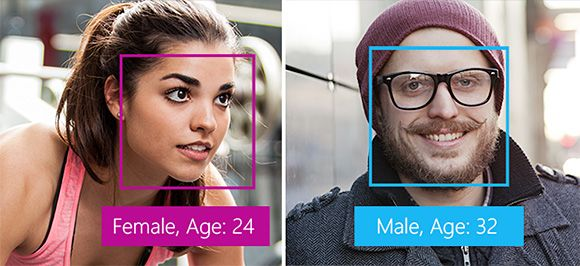

In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Creating DataFrame

In [2]:
'''
Splitting Age and Gender
'''
age=[]
gender=[]
img_path=[]
directory='/kaggle/input/utkface-new/UTKFace'
for name in os.listdir(directory):
    age.append(int(name.split('_')[0]))
    gender.append(int(name.split('_')[1]))
    img_path.append(name)

In [3]:
len(age)

23708

In [4]:
df=pd.DataFrame({'AGE':age,'GENDER':gender,'IMG':img_path})

In [5]:
df.head()

,AGE,GENDER,IMG
0,26,0,26_0_2_20170104023102422.jpg.chip.jpg
1,22,1,22_1_1_20170112233644761.jpg.chip.jpg
2,21,1,21_1_3_20170105003215901.jpg.chip.jpg
3,28,0,28_0_0_20170117180555824.jpg.chip.jpg
4,17,1,17_1_4_20170103222931966.jpg.chip.jpg


In [6]:
df.shape

(23708, 3)

In [7]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]

# Data Augmentation

In [8]:
'''
Functions for Data Augmentation
'''
train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True
                                )
test_datagen=ImageDataGenerator(rescale=1./255,)

In [9]:
'''
Passing data for Augmentation
'''
train_generator=train_datagen.flow_from_dataframe(train_df,
                                                 directory=directory,
                                                 x_col='IMG',
                                                 y_col=['AGE','GENDER'],
                                                 target_size=(200,200),
                                                 class_mode='multi_output')

test_generator=test_datagen.flow_from_dataframe(test_df,
                                                 directory=directory,
                                                 x_col='IMG',
                                                 y_col=['AGE','GENDER'],
                                                 target_size=(200,200),
                                                 class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


# Creating Functional Model

In [10]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [11]:
'''
Taking VGG16 as Pre-trained model
'''
vggnet=VGG16(include_top=False,input_shape=(200,200,3))

58889256/58889256 [==============================] - 2s 0us/step


In [12]:
'''
Model Architecture
'''
#Feature Extraction Functional Model
vggnet.trainable=False  

output=vggnet.layers[-1].output
flatten=Flatten()(output)

dense1=Dense(256,activation='relu')(flatten)
dense2=Dense(256,activation='relu')(flatten)

dense3=Dense(256,activation='relu')(dense1)
dense4=Dense(256,activation='relu')(dense2)

output1=Dense(1,activation='linear',name='AGE')(dense3)
output2=Dense(1,activation='sigmoid',name='GENDER')(dense4)

In [13]:
model=Model(inputs=vggnet.input,outputs=[output1,output2])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

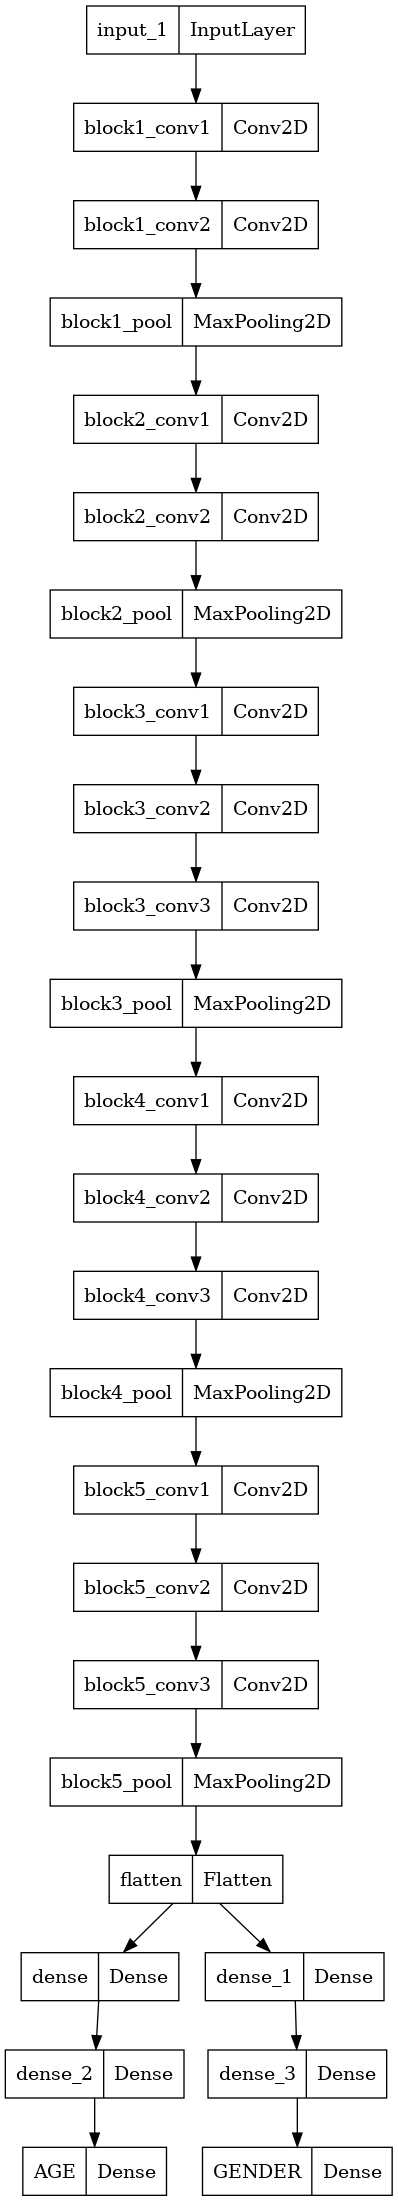

In [15]:
'''
Plotting Model
'''
from keras.utils import plot_model
plot_model(model)

In [16]:
model.compile(optimizer='adam',loss={'AGE':'mae','GENDER':'binary_crossentropy'},metrics={'AGE':'mae','GENDER':'accuracy'},loss_weights={'AGE':1,'GENDER':99})

In [17]:
'''
Training Fully Connected Layers
'''
model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 304s 470ms/step - loss: 62.1232 - AGE_loss: 11.0001 - GENDER_loss: 0.5164 - AGE_mae: 11.0001 - GENDER_accuracy: 0.7444 - val_loss: 42.6435 - val_AGE_loss: 8.6425 - val_GENDER_loss: 0.3434 - val_AGE_mae: 8.6425 - val_GENDER_accuracy: 0.8519
Epoch 2/10
625/625 [==============================] - 207s 331ms/step - loss: 52.8233 - AGE_loss: 9.4485 - GENDER_loss: 0.4381 - AGE_mae: 9.4485 - GENDER_accuracy: 0.7926 - val_loss: 41.2923 - val_AGE_loss: 8.5784 - val_GENDER_loss: 0.3304 - val_AGE_mae: 8.5784 - val_GENDER_accuracy: 0.8581
Epoch 3/10
625/625 [==============================] - 210s 336ms/step - loss: 51.6382 - AGE_loss: 9.0305 - GENDER_loss: 0.4304 - AGE_mae: 9.0305 - GENDER_accuracy: 0.7943 - val_loss: 40.9189 - val_AGE_loss: 8.0479 - val_GENDER_loss: 0.3320 - val_AGE_mae: 8.0479 - val_GENDER_accuracy: 0.8541
Epoch 4/10
625/625 [==============================] - 205s 328ms/step - loss: 49.0917 - AGE_loss: 8.7423 - GENDER_loss: 0.